In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.cuda.amp import autocast, GradScaler
from torch.cuda.amp import autocast
from joblib import load

In [6]:
class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len):
        super(LSTM_Autoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, input_size)
        self.hidden_size = hidden_size
        self.seq_len = seq_len

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        encoded, (hn, cn) = self.encoder(x, (h0, c0))
        decoded, _ = self.decoder(encoded, (hn, cn))
        decoded = self.output_layer(decoded)
        
        return decoded

In [11]:
def pipeline(data_recs, data_columns,):
    for idx, data_rec in enumerate(data_recs):
        print(f"Processing record {idx + 1}...")

        data_rec = pd.DataFrame([data_rec], columns=data_columns)

        missing_values = data_rec.isnull().sum()
        if len(missing_values[missing_values > 0]):
            print(missing_values[missing_values > 0])
            data_rec.fillna(0, inplace=True)
        else:
            print('No missing values in the record')

        for i in range(1, 21):
            if data_rec.iloc[0, i] not in [0, 1]:
                print(f"Invalid value in column {i}. Assigned value: 0")
                data_rec.iloc[0, i] = 0

        for i in range(21, 23):
            if (data_rec.iloc[0, i] < 1) or (data_rec.iloc[0, i] > 27):
                print(f"Invalid value in column {i}. Assigned value: 1")
                data_rec.iloc[0, i] = 1


        if 'Unnamed: 0' in data_rec.columns:
            data_rec = data_rec.drop(['Unnamed: 0'], axis=1)

        input_size = 25  
        hidden_size = 256
        seq_len = 1

        model_path = "./House B files/lstm_autoencoder_hb.pth"
        scaler_path = "./House B files/standardscaler_hb.joblib"
        reconstruction_error_path = "./House B files/reconstruction_errors_hb.npy"

        device = torch.device('cpu')
        model = LSTM_Autoencoder(input_size=input_size, hidden_size=hidden_size, seq_len=seq_len)

        state_dict = torch.load(model_path, map_location=device)
        if any(key.startswith("module.") for key in state_dict.keys()):
            state_dict = {key[len("module."):]: value for key, value in state_dict.items()}

        try:
            model.load_state_dict(state_dict)
        except RuntimeError as e:
            print(f"Error loading model: {e}")
            print("Ensure the model architecture matches the saved state_dict structure.")

        model.eval()

        reconstruction_errors = np.load(reconstruction_error_path)
        threshold = np.percentile(reconstruction_errors, 95)

        sc = load(scaler_path)
        new_data = sc.transform(data_rec)
        new_data_tensor = torch.tensor(new_data, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            new_data_reconstructed = model(new_data_tensor)
            reconstruction_error = torch.mean((new_data_tensor - new_data_reconstructed) ** 2).item()

        print(reconstruction_error,threshold)
        is_anomaly = reconstruction_error > threshold
        if is_anomaly:
            print(f"Record {idx + 1}: Current Record is an anomaly\n")
        else:
            print(f"Record {idx + 1}: Current Record is not an anomaly\n")

In [15]:
import warnings
warnings.filterwarnings("ignore")

# houseb = pd.read_csv("../Aras/house_b_combined_dataset.csv")

data_columns = ['Unnamed: 0', 'contact_kitchen_cupboard_1',
       'contact_kitchen_cupboard_2', 'contact_house_door',
       'contact_wardrobe_door_1', 'contact_wardrobe_door_2',
       'contact_shower_door', 'distance_tap', 'force_chair_1', 'force_chair_2',
       'force_chair_3', 'photocell_fridge', 'photocell_kitchen_drawer',
       'pressure_mat_couch_1', 'pressure_mat_couch_2', 'pressure_mat_bed_1',
       'pressure_mat_bed_2', 'pressure_mat_armchair', 'sonar_bathroom_door',
       'sonar_kitchen', 'sonar_closet', 'Resident1', 'Resident2', 'Hour',
       'Week', 'Day Of Week']

data_recs = [[10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,11,11,10,1.0,1.0]]

pipeline(data_recs, data_columns)

Processing record 1...
No missing values in the record
0.0005703194183297455 0.00014203230966813862
Record 1: Current Record is an anomaly



Min error = 5.640520157612627e-07 , Max Error  = 48.346717834472656


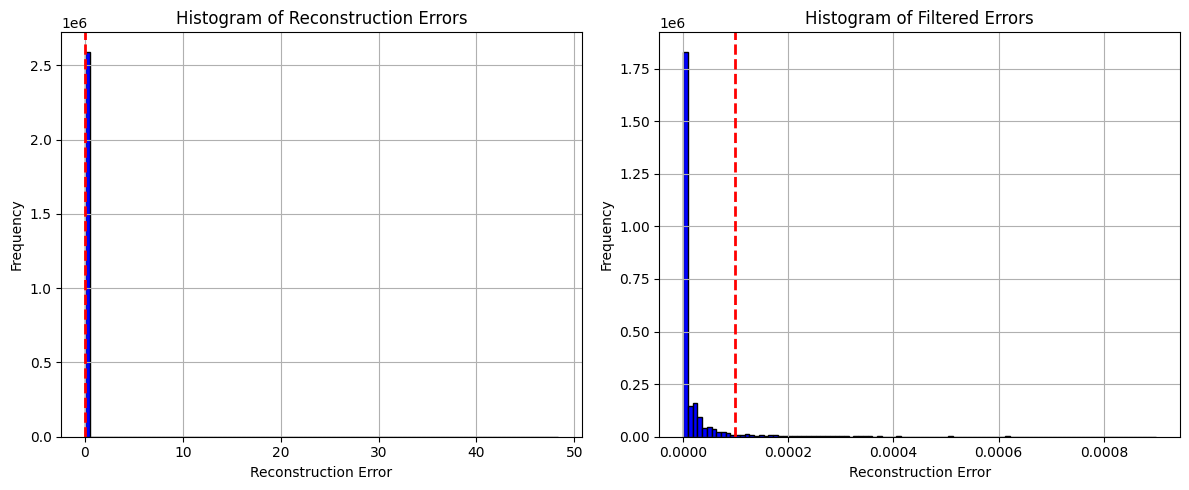

In [28]:
import matplotlib.pyplot as plt
import numpy as np

reconstruction_error_path = "./House B files/reconstruction_errors_hb.npy"
reconstruction_errors = np.load(reconstruction_error_path)

print(f"Min error = {np.min(reconstruction_errors)} , Max Error  = {np.max(reconstruction_errors)}")

filtered_errors = reconstruction_errors[reconstruction_errors < 0.0009]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(reconstruction_errors, bins=100, color='blue', edgecolor='black')
ax1.set_title('Histogram of Reconstruction Errors')
ax1.set_xlabel('Reconstruction Error')
ax1.set_ylabel('Frequency')
ax1.grid(True)
ax1.axvline(x=0.0001, color='red', linestyle='--', linewidth=2)

ax2.hist(filtered_errors, bins=100, color='blue', edgecolor='black')
ax2.set_title('Histogram of Filtered Errors')
ax2.set_xlabel('Reconstruction Error')
ax2.set_ylabel('Frequency')
ax2.grid(True)
ax2.axvline(x=0.0001, color='red', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()